In [206]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB

In [207]:
# Load data
data = pd.read_csv('https://otf.ca/sites/default/files/OTF-Grants_since2000.csv')

In [208]:
# Clean data
data = data.drop(columns=['Funding Org:Org subventionnaire', 'Country Served:Pays servis', 'Province Served:Province servis', 'Cross-catchment indicator:Indicateur interrégional', 'Co-Application:Co-demandeurs', 'Description (French/Français)', 'Grant Result:Résultat de subvention','Rescinded/Recovered:Révoqué/récupéré','Rescinded/Recovered Initiated By:Révoqué/récupéré intié par','Amount Rescinded/Recovered:Montant révoqué/récupéré', 'Last modified:Mise à jour'])
data.columns = ['fiscal_year','grant_program','geographical_area','identifier','org_name','submission_date', 'approval_date', 'amount_applied', 'amount_awarded', 'planned_duration', 'description', 'program_area', 'budget_fund', 'org_incorporation_num', 'org_charitable_reg_num', 'org_city', 'org_postcode', 'population_served', 'age_group']
description = pd.DataFrame(data, columns = ['description'])

# Remove structured text and keep only free-form text
a = description['description'].str.split('programs for Ontarians by ').str[1].dropna()
b = description['description'].str.split('grant over \d+ years to ').str[1].dropna()
c = description['description'].str.split('rebuild and recover from impacts of COVID-19 by ').str[1].dropna()
d = description['description'].str.split('grant over \d+ months to ').str[1].dropna()
e = description['description'].str.split('\$\d+( \w+|[\d,]+) over \d+ months to ').str[2].dropna()
f = description['description'].str.split('\$\d+( \w+|[\d,]+) over one year to ').str[2].dropna()
g = description['description'].str.split('\$\d+( \w+|[\d,]+) over two years to ').str[2].dropna()
h = description['description'].str.split('\$\d+( \w+|[\d,]+) over three years to ').str[2].dropna()
i = description['description'].str.split('\$\d+( \w+|[\d,]+) over six months to ').str[2].dropna()
j = description['description'].str.split('This project aims to ').str[1].dropna()

description_clean = pd.concat([a, b, c, d, e, f, g, h, i, j], axis=0,ignore_index=False)
description_clean = description_clean.to_frame()

add_indices = pd.Index(range(27952)).difference(description_clean.index)
add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
description_clean = pd.concat([description_clean, add_df])

In [209]:
add_indices = pd.Index(range(27952)).difference(description_clean.index)
add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
description_clean = pd.concat([description_clean, add_df])

In [210]:
# Extract features
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 300, stop_words = 'english')
counts_sparse = vectorizer.fit_transform(description_clean['description'])
counts = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
counts = counts.drop(counts.columns[0:11], axis=1) 

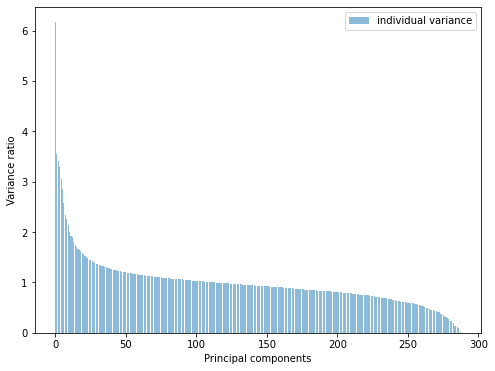

In [211]:
# For clusterer
# Visualize variance across features to reduce dimensions
enconder = LabelEncoder()
for col in counts.columns:
    counts[col] = enconder.fit_transform(counts[col])
    
counts_features = counts.iloc[:,1:289]
counts_label = counts.iloc[:,0]

scaler = StandardScaler()
counts_features = scaler.fit_transform(counts_features)
    
pca = PCA()
pca.fit_transform(counts_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(288), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

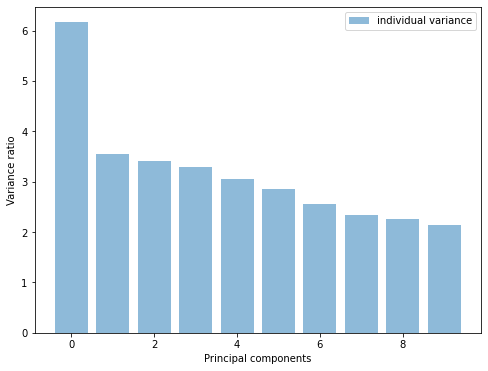

In [212]:
# Reduce features
pca2 = PCA(n_components=10)
pca2.fit(counts_features)
counts_reduced = pca2.transform(counts_features)

pca_variance2 = pca2.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(10), pca_variance2, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

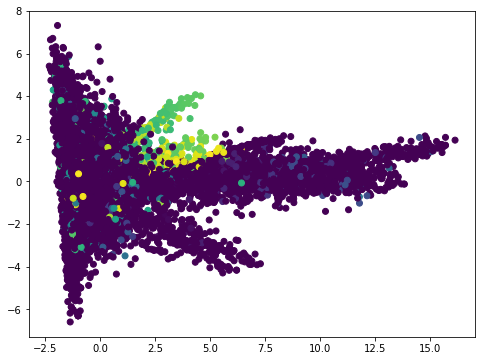

In [213]:
plt.figure(figsize=(8,6))
plt.scatter(counts_reduced[:,0], counts_reduced[:,9], c=counts[col])
plt.show()

In [214]:
# Find best number of clusters and apply model (full features)
sil_scores = []
for k in range(3,9):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(counts)
    label = clusterer.predict(counts)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(counts, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label']
best_label

# Present some summary statistics for each clusters
pd.DataFrame(counts).groupby(best_label).mean()

,abilities,able,aboriginal,access,accessibility,accessible,active,activities,activity,additional,...,website,wellbeing,women,work,workshops,year,years,york,young,youth
0,1.003156,12.352972,0.089427,29.047344,3.775907,39.701736,132.739611,96.415571,13.099947,0.192530,...,0.048396,55.709100,3.722777,2.397685,3.330878,2.601789,1.185692,0.712783,6.217780,264.872699
1,4.027094,3.625930,1.786260,58.672786,6.353008,35.519008,6.952832,66.932498,10.246243,2.821988,...,4.448333,0.284050,13.727027,13.330074,14.468667,54.959332,66.027719,4.122575,16.525664,402.356493
2,6.275245,4.435439,0.984171,82.970101,11.214568,65.972006,12.437491,105.819581,11.171039,1.918804,...,2.206214,2.850799,6.902829,15.206214,9.429430,59.080756,48.752895,4.277444,10.195369,226.825150


In [215]:
# Apply model with manually set number of clusters (full features)
manual_clusterer = KMeans(n_clusters=6)
manual_clusterer.fit(counts)
manual_label = manual_clusterer.predict(counts)
pd.DataFrame(counts).groupby(manual_label).mean()

,abilities,able,aboriginal,access,accessibility,accessible,active,activities,activity,additional,...,website,wellbeing,women,work,workshops,year,years,york,young,youth
0,0.842692,2.121800,2.211396,47.130884,2.699009,15.158960,4.052436,75.132948,9.195293,3.935178,...,4.058629,0.461602,26.481007,17.664740,11.659372,60.876961,114.858794,4.492568,21.288604,418.460363
1,3.985335,2.868331,0.818097,91.130733,11.146958,74.324181,6.292044,107.642746,7.798128,1.631513,...,1.791264,0.317629,6.121373,13.269267,7.520125,68.849298,43.716381,3.564119,9.485491,258.143526
2,4.340424,3.620250,1.688991,60.086921,6.777869,38.925451,7.149224,64.191769,10.272567,2.687287,...,4.656862,0.274208,12.132938,12.543808,14.785254,55.342002,60.226297,4.045512,16.252556,411.507954
3,0.777599,12.584673,0.091104,26.057342,3.846731,36.936227,134.455520,96.161308,13.345659,0.196141,...,0.049303,56.754019,3.792605,2.016613,3.435691,2.091104,0.265273,0.726152,6.111468,261.879421
4,10.017027,6.940270,1.576486,83.243243,11.972432,61.185946,11.047027,113.773784,15.462432,2.672432,...,3.039189,0.146486,8.544324,14.320541,14.308378,57.624054,62.123514,5.647027,12.242162,235.032162
5,0.077342,2.857298,0.539216,37.906318,5.166667,23.641612,39.093682,52.336601,6.570806,0.148148,...,0.000000,19.489107,3.785403,25.984749,3.230937,3.183007,1.945534,1.275599,3.289760,76.043573


In [313]:
# For classifier
# Set up data
vectorizer2 = TfidfVectorizer(ngram_range=(1,1), max_features = 10, stop_words = 'english')
counts_sparse2 = vectorizer2.fit_transform(description_clean['description'])
counts2 = pd.DataFrame(counts_sparse2.toarray(), index=description_clean.index, columns=vectorizer2.get_feature_names())
counts2 = counts2.drop(counts2.columns[0:11], axis=1) 

classif_data = pd.DataFrame(data, columns = ['grant_program'])
p_a = pd.get_dummies(data['program_area'])
p_s = pd.get_dummies(data['population_served'])
a_g = pd.get_dummies(data['age_group'])
classif_data = classif_data.join([p_a,p_s,a_g,counts2])

In [307]:
# Split data
training = classif_data.head(22363)
testing = classif_data.tail(5591)
holdout = training.sample(5000, random_state=3)
training = training.drop(holdout.index)

# Apply model - holdout
classifier = MultinomialNB()
holdout_observations = pd.DataFrame(holdout)[training.drop('grant_program', axis=1).columns]
classifier.fit(training.drop(['grant_program'],axis=1), training['grant_program'])

# Make prediction - holdout
holdout_prediction = classifier.predict(holdout_observations)

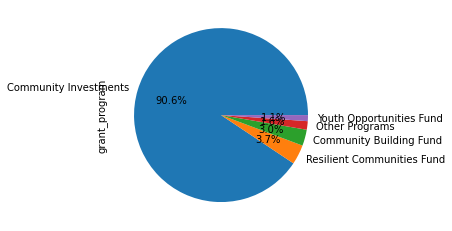

In [308]:
# Visualize prediction - holdout
holdout_prediction_df = pd.DataFrame(holdout_prediction, columns = ['grant_program'])
holdout_prediction_df['grant_program'].value_counts().plot.pie(autopct='%1.1f%%')

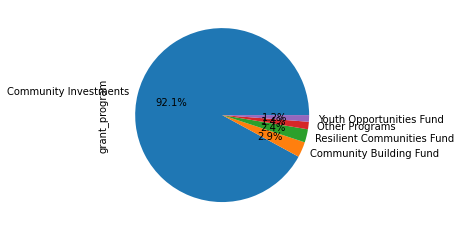

In [309]:
# Visualize training for comparison
training['grant_program'].value_counts().plot.pie(autopct='%1.1f%%')

In [310]:
# Get accuracy of holdout model
from sklearn.metrics import accuracy_score
estimated_accuracy = accuracy_score(holdout['grant_program'], holdout_prediction_df['grant_program'])
estimated_accuracy

0.9652

In [98]:
#pd.DataFrame(counts).to_csv('counts.csv', index=True, header=False)

In [156]:
#pd.DataFrame(description).to_csv('desc.csv', index=True, header=False)